# Example 3: -  Including systematics

Johann Brehmer, Felix Kling, Kyle Cranmer 2018

In this tutorial we will demonstrate how to include systematics in a MadMiner analysis. As physics example, we will consider $ZH \to \mu\mu \tau\tau$ production at parton level, with smearing functions. 

## Preparations

Let us first load all the python libraries again

In [3]:
import sys
import os
madminer_src_path = "/Users/felixkling/Documents/GitHub/madminer"
sys.path.append(madminer_src_path)

from __future__ import absolute_import, division, print_function, unicode_literals

import logging
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
% matplotlib inline

from madminer.core import MadMiner
from madminer.plotting import plot_2d_morphing_basis
from madminer.sampling import combine_and_shuffle
from madminer.lhe import LHEProcessor
from madminer.sampling import SampleAugmenter
from madminer.plotting import plot_distributions

Please enter here the path to your MG5 root directory. This notebook assumes that you installed Delphes and Pythia through MG5. **This needs to be updated by the user**

In [2]:
mg_dir = '/Users/felixkling/work/MG5_aMC_v2_6_2'

MadMiner uses the Python `logging` module to provide additional information and debugging output. You can choose how much of this output you want to see by switching the level in the following lines to `logging.DEBUG` or `logging.WARNING`.

In [4]:
logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.INFO
)

for key in logging.Logger.manager.loggerDict:
    if "madminer" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)

## 1. Setup

### 1a) Parameter Space

Let us first define the theory parameters. We are again using the `EWdim6` model 

In [3]:
miner = MadMiner()

miner.add_parameter(
    lha_block='dim6',
    lha_id=2,
    parameter_name='CWL2',
    morphing_max_power=2,
    parameter_range=(-50.,50.)
)
miner.add_parameter(
    lha_block='dim6',
    lha_id=3,
    parameter_name='CBL2',
    morphing_max_power=2,
    parameter_range=(-50.,50.)
)

### 1b) Benchmarks

Define SM benchmarks by hand, and scan to find remaining benchmarks.

In [4]:
miner.add_benchmark( {'CWL2':0., 'CBL2':0.}, 'sm')

In [5]:
miner.set_morphing(
    include_existing_benchmarks=True,
    n_trials=1000,
    max_overall_power=2
)

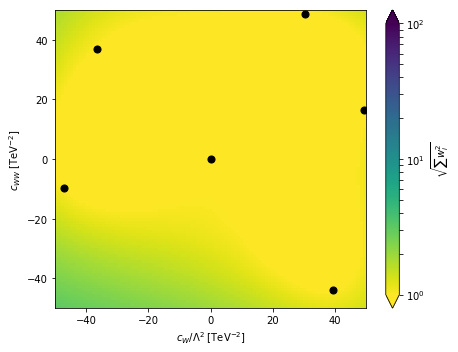

In [6]:
fig = plot_2d_morphing_basis(
    miner.morpher,
    xlabel=r'$c_{W} / \Lambda^2$ [TeV$^{-2}$]',
    ylabel=r'$c_{WW}} / \Lambda^2$ [TeV$^{-2}$]',
    xrange=(-50,50),
    yrange=(-50,50)
)

### 1c) Systematics

Systematics can be added using the `madminer.set_systematics()` command. In particular, we consider two sorts of systematics: scale variations and pdf variations. The setting is described by the following three inputs
- `scales`: Whether only the regularization scale (`"mur"`), only the factorization scale (`"muf"`), both simultanously with $\mu=\mu_F=\mu_R$ (`"together"`) or both independently (`"independent"`) are varied.
- `scale_variation`: If not `None`, the regularization and / or factorization scales are varied. A tuple like ($\mu_{max},\mu_{min}$) specifies the factors with which they are varied. Here $\mu_{max}$ refers to the name of the benchmark with $\nu = 1$, while $\mu_{min}$ is either `None` or refers to the name of the benchmark with $\nu = -1$. Note that if more than two scales are given, currently only first and last scale are used.
- `pdf_variation`: If not `None`, the PDFs are varied. The option is passed along to the `--pdf` option of MadGraph's systematics module. See https://cp3.irmp.ucl.ac.be/projects/madgraph/wiki/Systematics for a list. For example, the option `"90900"` would run over all the eigenvectors of the PDF4LHC15_nlo_30 set. 

In [7]:
miner.set_systematics(
    scale_variation=(0.5,1,2), 
    scales="independent", 
    pdf_variation="90900"
)

### 1d) Save setup

In [8]:
miner.save('data/madminer_example.h5')

## 2. Event Generation

Load MadMiner again

In [16]:
miner.load('data/madminer_example.h5')

NameError: name 'miner' is not defined

We now run MadMiner for the signal: 

In [10]:
miner.run(
    mg_directory=mg_dir,
    mg_process_directory='./mg_processes/signal',
    log_directory='logs/signal',
    sample_benchmark='sm',
    proc_card_file='cards/proc_card_signal.dat',
    param_card_template_file='cards/param_card_signal.dat',
    run_card_file='cards/run_card.dat',
    pythia8_card_file=None,
    initial_command='source ~/.bashrc'
)

## 3. Extract Parton Level Observables / Weights 

### 3a) Setting up LHEProcessor 

We first initialize the the LHEProcessor and add the LHE file

In [4]:
lhep = LHEProcessor('data/madminer_example.h5')

lhep.add_sample(
    'mg_processes/signal/Events/run_01/unweighted_events.lhe.gz',
    sampled_from_benchmark="sm",
    k_factor=1.0
)

### 3b) Smearing Functions

Instead of performing a proper proper shower and detector simulation, we can simulate smearing effects at parton level smearing through smearing functions. Here we will assume a simple 10% uncertainty on the tau energy measurements and a $\pm 0.05$ smearing for tau $\eta$ and $\phi$. The transverse momenta of the taus are then derived from the smeared energy and the on-shell condition for the quarks (this is what `pt_resolution_abs=None` does). The leptons from the Z-boson decay are assumed to be measured perfectly (otherwise we'd have to call `set_smearing` another time with `pdgis=[-13 13]`).

In [5]:
lhep.set_smearing(
    pdgids=[-15, 15],   
    energy_resolution_abs=0.05,
    energy_resolution_rel=0,
    pt_resolution_abs=None,
    pt_resolution_rel=None,
    eta_resolution_abs=0.02,
    eta_resolution_rel=0,
    phi_resolution_abs=0.02,
    phi_resolution_rel=0,
)

### 3c) Add Observables and Cuts

We will now add some observables.  In the expression string, you can use the terms `j[i]`, `e[i]`, `mu[i]`, `tau[i]`,  `a[i]`, `met`, where the indices `i` refer to a ordering by the transverse momentum. In addition, you can use `p[i]`, which denotes the `i`-th particle in the order given in the LHE sample (which is the order in which the final-state particles where defined in MadGraph).

Here we on a small set of higher-level observables: 

In [6]:
lhep.add_observable('m_Z', '(mu[0]+mu[1]).m',required=True)
lhep.add_observable('m_H', '(tau[0]+tau[1]).m',required=True)
lhep.add_observable('m_ZH', '(mu[0]+mu[1]+tau[0]+tau[1]).m',required=True)
lhep.add_observable('pt_Z', '(mu[0]+mu[1]).pt',required=True)
lhep.add_observable('pt_H', '(tau[0]+tau[1]).pt',required=True)
lhep.add_observable('eta_Z', '(mu[0]+mu[1]).eta',required=True)
lhep.add_observable('eta_H', '(tau[0]+tau[1]).eta',required=True)
lhep.add_observable('dphi_mumu', 'mu[0].deltaphi(mu[1])',required=True)
lhep.add_observable('dphi_mupmum', 'p[0].deltaphi(p[1])',required=True)
lhep.add_observable('dphi_tata', 'tau[0].deltaphi(tau[1])',required=True)
lhep.add_observable('dphi_mupH', 'p[0].deltaphi(tau[0]+tau[1])',required=True)
lhep.add_observable('dphi_mumH', 'p[1].deltaphi(tau[0]+tau[1])',required=True)
lhep.add_observable('pt_mup', 'p[0].pt',required=True)
lhep.add_observable('pt_mum', 'p[1].pt',required=True)

We can also add cuts, again in parse-able strings. In addition to the objects discussed above, they can contain the observables. As example, we consider cuts on the invariant di-lepton / di-tau mass:

In [7]:
lhep.add_cut('m_Z > 86')
lhep.add_cut('m_Z < 96')
lhep.add_cut('(tau[0]+tau[1]).m > 120')
lhep.add_cut('(tau[0]+tau[1]).m < 130')

### 3d) Run and Save 

We can now run `analyse_samples` to calculate all observables from the LHE file(s) generated before, apply the smearing, and check which events pass the cuts:

In [8]:
lhep.analyse_samples() 

12:22 madminer.lhe         INFO    Analysing LHE sample mg_processes/signal/Events/run_01/unweighted_events.lhe.gz


Finally, let's save everything

In [9]:
lhep.save('data/madminer_lhedata_signal.h5')

### 3e) Plot Distributions

Let us now plot some distributions. This can also be done using the `plot_distributions` function. As before the function requires
- `filename`: the name of the file with the processed LHE data
- `parameter_points`: a list of benchmarks, which can either be specified by there name (such as `sm`) or manually (for example `np.array([0,1])`). 
- `line_labels`: names for the benchmarks
- `observables`: list of observables to be plotted (when `None`, all observables are plotted)
We can also plot the uncertainties using the option `uncertainties='nuisance'`. By default, the full uncertainy band using all considered nuicanse parameter is shown. To obtain the uncertainty, MadMiner created a set of `n_toys` (default 100) Monte Carlo sample distributions to estimate the 68% CL band. Additionally, MadMiner can also show a set of `N` of these Monte Carlo toy samples using the option `draw_nuisance_toys=N`. 

More options, in particular regarding plotting, can be found via the command `help(plot_distributions)`. 

12:42 madminer.sampling    INFO    Loading data from data/madminer_lhedata_signal.h5
12:42 madminer.sampling    INFO    Found 2 parameters
12:42 madminer.sampling    DEBUG      CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
12:42 madminer.sampling    DEBUG      CBL2 (LHA: dim6 3, maximal power in squared ME: (2,), range: (-50.0, 50.0))
12:42 madminer.sampling    INFO    Found 33 nuisance parameters
12:42 madminer.sampling    DEBUG      mur ((u'35', u'6'))
12:42 madminer.sampling    DEBUG      muf ((u'25', u'16'))
12:42 madminer.sampling    DEBUG      pdf_0 ((u'45', None))
12:42 madminer.sampling    DEBUG      pdf_1 ((u'46', None))
12:42 madminer.sampling    DEBUG      pdf_2 ((u'47', None))
12:42 madminer.sampling    DEBUG      pdf_3 ((u'48', None))
12:42 madminer.sampling    DEBUG      pdf_4 ((u'49', None))
12:42 madminer.sampling    DEBUG      pdf_5 ((u'50', None))
12:42 madminer.sampling    DEBUG      pdf_6 ((u'51', None))
12:42 madminer.sampling    DEBUG

12:42 madminer.sampling    DEBUG     12 pt_mup
12:42 madminer.sampling    DEBUG     13 pt_mum
12:42 madminer.sampling    INFO    Found 8461 events
12:42 madminer.sampling    INFO    Found morphing setup with 6 components
12:42 madminer.sampling    INFO    Found nuisance morphing setup
12:42 madminer.plotting    DEBUG   Observable indices: [0, 2, 7]
12:42 madminer.plotting    DEBUG   Loaded raw data with shapes (8461, 14), (8461, 81)
12:42 madminer.plotting    DEBUG   Calculated 1 theta matrices
12:42 madminer.plotting    DEBUG   Drawing nuisance toys
12:42 madminer.plotting    DEBUG   Drew 3300 toy values for nuisance parameters
12:42 madminer.plotting    DEBUG   Plotting panel 0: observable 0, label m_Z
12:42 madminer.plotting    DEBUG   Ranges for observable m_Z: min = [87.37340749305547], max = [94.74506808593785]
12:42 madminer.plotting    DEBUG   Plotting panel 1: observable 2, label m_ZH
12:42 madminer.plotting    DEBUG   Ranges for observable m_ZH: min = [210.46897354863034], ma

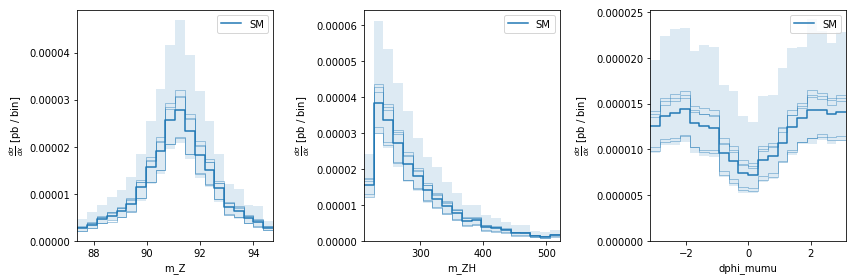

In [5]:
fig = plot_distributions(
    filename='data/madminer_lhedata_signal.h5',
    parameter_points=['sm'],
    line_labels=['SM'],
    observables=['m_Z','m_ZH','dphi_mumu'],
    uncertainties='nuisance',
    n_toys=100,
    n_bins=20,               
    normalize=False,  
    draw_nuisance_toys=5
)

We can also only consider a subset of nuisance parameter. In the following example, we separatly show the uncertainties from scale and PDF variations.  

12:23 madminer.sampling    INFO    Loading data from data/madminer_lhedata_signal.h5
12:23 madminer.sampling    INFO    Found 2 parameters
12:23 madminer.sampling    INFO    Found 33 nuisance parameters
12:23 madminer.sampling    INFO    Found 81 benchmarks, of which 6 physical
12:23 madminer.sampling    INFO    Found 14 observables
12:23 madminer.sampling    INFO    Found 8461 events
12:23 madminer.sampling    INFO    Found morphing setup with 6 components
12:23 madminer.sampling    INFO    Found nuisance morphing setup
12:23 madminer.sampling    INFO    Loading data from data/madminer_lhedata_signal.h5
12:23 madminer.sampling    INFO    Found 2 parameters
12:23 madminer.sampling    INFO    Found 33 nuisance parameters
12:23 madminer.sampling    INFO    Found 81 benchmarks, of which 6 physical
12:23 madminer.sampling    INFO    Found 14 observables
12:23 madminer.sampling    INFO    Found 8461 events
12:23 madminer.sampling    INFO    Found morphing setup with 6 components
12:23 madmi

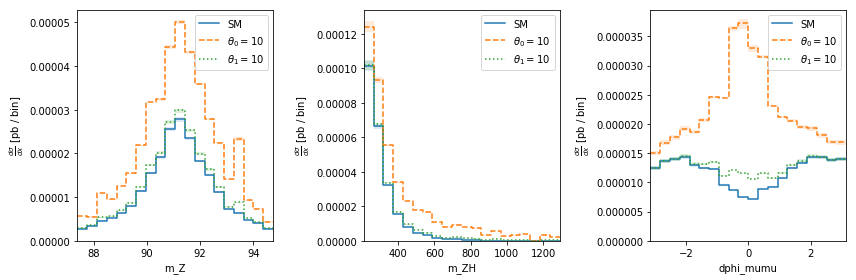

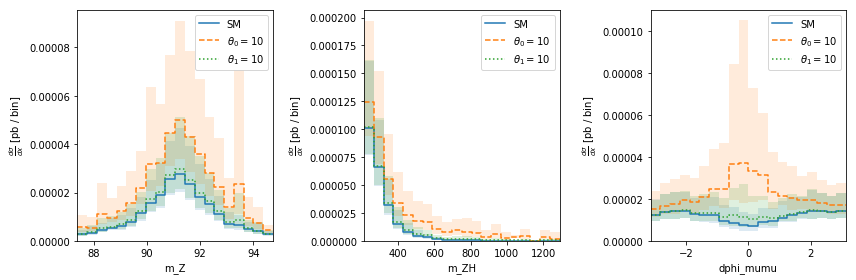

In [11]:
nuisance_scale=np.array([i for i in range(0,2)])
nuisance_pdf=np.array([i for i in range(2,33)])

fig_scale = plot_distributions(
     filename='data/madminer_lhedata_signal.h5',
    parameter_points=['sm',np.array([10,0]),np.array([0,10])],
    line_labels=['SM',r'$\theta_0=10$',r'$\theta_1=10$'],
    observables=['m_Z','m_ZH','dphi_mumu'],
    uncertainties='nuisance',
    n_bins=20,               
    normalize=False,  
    nuisance_parameters=nuisance_scale,
)

fig_pdf = plot_distributions(
     filename='data/madminer_lhedata_signal.h5',
    parameter_points=['sm',np.array([10,0]),np.array([0,10])],
    line_labels=['SM',r'$\theta_0=10$',r'$\theta_1=10$'],
    observables=['m_Z','m_ZH','dphi_mumu'],
    uncertainties='nuisance',
    n_bins=20,               
    normalize=False,  
    nuisance_parameters=nuisance_pdf,
)

Note that the uncertainty mainly effects the signal normalization, not the signal distribution. This can be seen looking at the normalized distributions via `normalize=True`

12:23 madminer.sampling    INFO    Loading data from data/madminer_lhedata_signal.h5
12:23 madminer.sampling    INFO    Found 2 parameters
12:23 madminer.sampling    INFO    Found 33 nuisance parameters
12:23 madminer.sampling    INFO    Found 81 benchmarks, of which 6 physical
12:23 madminer.sampling    INFO    Found 14 observables
12:23 madminer.sampling    INFO    Found 8461 events
12:23 madminer.sampling    INFO    Found morphing setup with 6 components
12:23 madminer.sampling    INFO    Found nuisance morphing setup


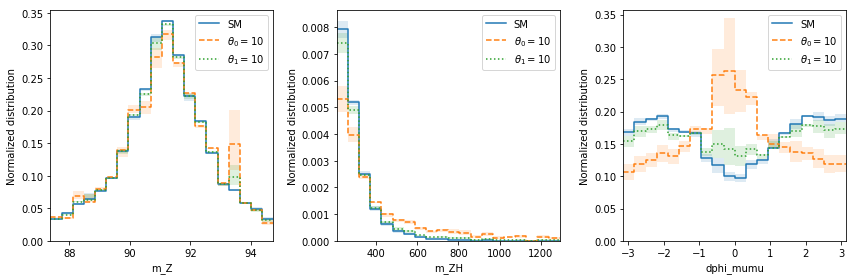

In [12]:
fig_pdf = plot_distributions(
     filename='data/madminer_lhedata_signal.h5',
    parameter_points=['sm',np.array([10,0]),np.array([0,10])],
    line_labels=['SM',r'$\theta_0=10$',r'$\theta_1=10$'],
    observables=['m_Z','m_ZH','dphi_mumu'],
    uncertainties='nuisance',
    n_bins=20,               
    normalize=True,  
)